In [1]:

import numpy as np
import pandas as pd
import networkx as nx
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline


## BTC transactions

In [3]:
data_matrix = pd.read_csv('Data.csv',names = ['From','To','Rating','Timestamp'])

In [4]:
data_matrix.head()

,From,To,Rating,Timestamp
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


## EDA

Text(0, 0.5, 'Frequency')

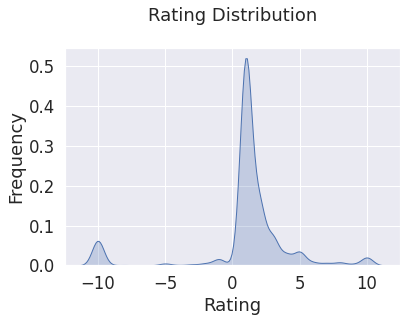

In [111]:
# ratings distribution
sns.kdeplot(data_matrix['Rating'], shade = True)
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Frequency')

/home/ml-lab/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '-10'),
  Text(1, 0, '-5'),
  Text(2, 0, '-3'),
  Text(3, 0, '-2'),
  Text(4, 0, '-1'),
  Text(5, 0, '1'),
  Text(6, 0, '2'),
  Text(7, 0, '3'),
  Text(8, 0, '4'),
  Text(9, 0, '5'),
  Text(10, 0, '6'),
  Text(11, 0, '7'),
  Text(12, 0, '8'),
  Text(13, 0, '9'),
  Text(14, 0, '10')])

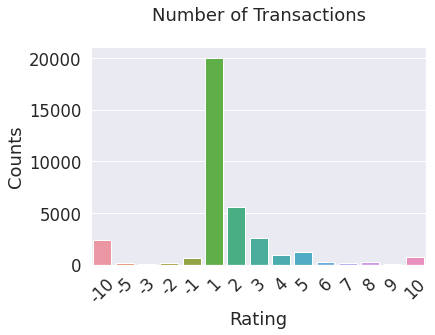

In [114]:
# number of edges per rating
sns.barplot(data_matrix['Rating'].value_counts().head(15).index, data_matrix['Rating'].value_counts().head(15))
plt.title('Number of Transactions\n')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.xticks(rotation=45)

In [ ]:
# highest rated edges
popular_books = data_matrix.nlargest(10, ['ratings_count']).set_index('title')['ratings_count']
sns.barplot(popular_books, popular_books.index)

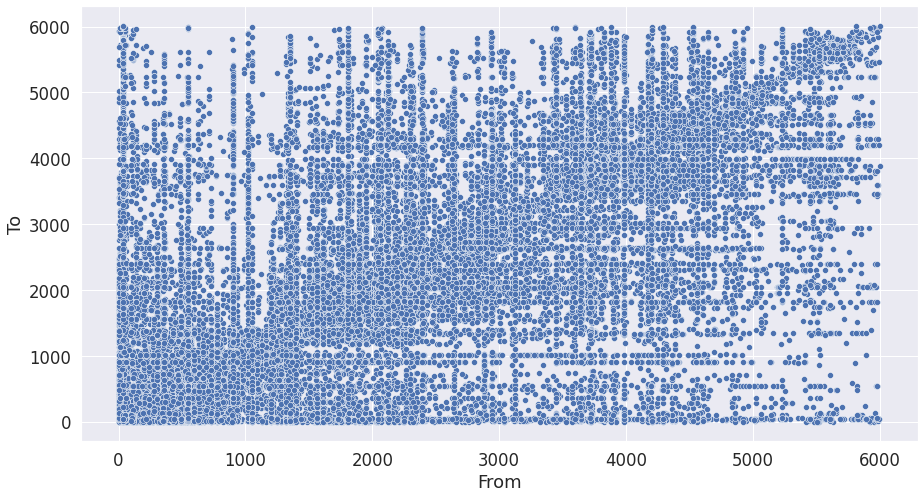

In [12]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
ax = sns.scatterplot(x = data_matrix.From,y= data_matrix.To)

It can be seen from the above plot that most of the source nodes have given positive rating and it very concentrated. This gives the intuition of creating two features fairness and goodness which will be discussed below.

# Graph

In [18]:
G = nx.DiGraph()
edges=[(data_matrix["From"][i],data_matrix["To"][i],data_matrix["Rating"][i]/10) for i in data_matrix.index]
edges

[(6, 2, 0.4),
 (6, 5, 0.2),
 (1, 15, 0.1),
 (4, 3, 0.7),
 (13, 16, 0.8),
 (13, 10, 0.8),
 (7, 5, 0.1),
 (2, 21, 0.5),
 (2, 20, 0.5),
 (21, 2, 0.5),
 (21, 1, 0.8),
 (21, 10, 0.8),
 (21, 8, 0.9),
 (21, 3, 0.7),
 (17, 3, 0.5),
 (17, 23, 0.1),
 (10, 1, 0.8),
 (10, 6, 0.7),
 (10, 21, 0.8),
 (10, 8, 0.1),
 (10, 25, 1.0),
 (10, 2, 0.7),
 (10, 3, 0.7),
 (4, 26, 0.1),
 (26, 4, 0.1),
 (5, 1, 0.3),
 (5, 6, 0.3),
 (5, 7, 0.1),
 (1, 5, 0.4),
 (6, 4, 0.2),
 (4, 6, 0.5),
 (2, 4, 0.5),
 (17, 28, 0.1),
 (17, 13, 0.2),
 (13, 17, 0.2),
 (13, 29, 0.2),
 (29, 13, 0.2),
 (17, 20, 0.2),
 (4, 31, 0.1),
 (31, 4, 0.2),
 (32, 6, 0.1),
 (13, 1, 0.8),
 (7, 34, 0.1),
 (34, 7, 0.1),
 (32, 1, 0.1),
 (1, 32, 0.1),
 (1, 34, 0.1),
 (34, 1, 0.1),
 (34, 13, 0.1),
 (13, 34, 0.1),
 (6, 7, 0.5),
 (7, 6, 0.3),
 (1, 17, 0.9),
 (1, 31, 0.2),
 (31, 1, 0.3),
 (35, 6, 0.2),
 (1, 13, 0.3),
 (36, 37, 0.1),
 (37, 36, 0.1),
 (35, 1, 0.1),
 (17, 1, 0.9),
 (8, 1, 0.3),
 (7, 29, 0.2),
 (1, 20, 0.2),
 (37, 44, 0.1),
 (44, 37, 0.1),
 (39, 

In [19]:
for edge in edges:
    G.add_edge(edge[0],edge[1],weight=edge[2])

In [20]:
print(len(G.edges()))
print(len(G.nodes()))

35592
5881


## Feature Engineering

In [21]:
def initialize_scores(G):
    fairness = {}
    goodness = {}
    
    nodes = G.nodes()
    for node in nodes:
        fairness[node] = 1
        try:
            goodness[node] = G.in_degree(node, weight='weight')*1.0/G.in_degree(node)
        except:
            goodness[node] = 0
    return fairness, goodness

# Features

In [22]:
def compute_fairness_goodness(G):
    fairness, goodness = initialize_scores(G)
    
    nodes = G.nodes()

    while True:
        df = 0
        dg = 0

        print("Iteration number", iter)
        
        print('Updating goodness')
        for node in nodes:
            inedges = G.in_edges(node, data='weight')
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]

            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass

        print('Updating fairness')
        for node in nodes:
            outedges = G.out_edges(node, data='weight')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        
        print('Differences in fairness score and goodness score = %.2f, %.2f' % (df, dg))
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        
    
    return fairness, goodness

In [23]:
# these two dictionaries have the required scores
fairness, goodness = compute_fairness_goodness(G)

Iteration number <built-in function iter>
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 382.21, 0.00
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 34.47, 102.29
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 2.39, 6.97
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.39, 1.06
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.10, 0.24
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.03, 0.06
Iteration number <built-in function iter>
Updating goodness
Updating fairness
Differences in fairness score and goodness score = 0.01, 0.02
Iteration numbe

## Visualisation

In [24]:
a= [i for i,j in fairness.items() ]
b = [j for i,j in fairness.items()]
print(len(a),b)

5881 [0.895725519589204, 0.8937438727755906, 0.9401114372757616, 0.9224364178283305, 0.9604893190993837, 0.8912871984696537, 1, 0.9455630055117719, 1, 0.713045549965856, 0.9438444190253923, 0.8807172099458485, 1, 0.9880334901397252, 0.9186382873341592, 0.9347964708903963, 1, 0.9337386393011995, 0.9608730647843379, 0.972792447360182, 0.9723667238487769, 0.9258319700862093, 0.9238532955481142, 0.9830143667602695, 0.9679313502408943, 0.9445277419086083, 0.9450026744060911, 0.8923911541714011, 0.9228034119197932, 0.9184778713104245, 0.9629327604510792, 0.9276231591696986, 0.9470228936705524, 0.9591249300357105, 0.9528667309250523, 0.9215564303461556, 0.9621529896141624, 0.9172128281996721, 0.9249984397564893, 0.8291204973106187, 0.9865823963635704, 0.9674292223834459, 0.9566999575578286, 0.9536124159225573, 0.9677876825238978, 0.7619665098602748, 0.9604823897559759, 0.8880334901397252, 0.951680521356355, 0.964701014800994, 0.9283548662650446, 0.923713428055386, 0.9498871271030758, 0.938132

<AxesSubplot:>

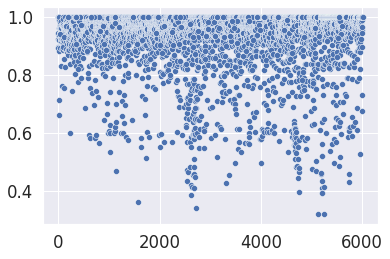

In [25]:
sns.scatterplot(x = a,y= b)

In [30]:
df

,From,To,Rating,Timestamp
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09
...,...,...,...,...
35587,4499,1810,1,1.453612e+09
35588,2731,3901,5,1.453679e+09
35589,2731,4897,5,1.453679e+09
35590,13,1128,1,1.453680e+09


In [32]:
def my_function(row):
    return fairness[row]

df=data_matrix.copy()
df['fairness'] = df['From'].apply(my_function)

In [33]:
df.head()

,From,To,Rating,Timestamp,fairness
0,6,2,4,1.289242e+09,0.895726
1,6,5,2,1.289242e+09,0.895726
2,1,15,1,1.289243e+09,0.922436
3,4,3,7,1.289245e+09,0.891287
4,13,16,8,1.289254e+09,0.945563


In [35]:
def my_function2(row):
    return goodness[row]

df['goodness'] = df['To'].apply(my_function)

In [36]:
df.head()

,From,To,Rating,Timestamp,fairness,goodness
0,6,2,4,1.289242e+09,0.895726,0.893744
1,6,5,2,1.289242e+09,0.895726,0.940111
2,1,15,1,1.289243e+09,0.922436,0.960489
3,4,3,7,1.289245e+09,0.891287,1.000000
4,13,16,8,1.289254e+09,0.945563,1.000000


In [37]:
df.head()

,From,To,Rating,Timestamp,fairness,goodness
0,6,2,4,1.289242e+09,0.895726,0.893744
1,6,5,2,1.289242e+09,0.895726,0.940111
2,1,15,1,1.289243e+09,0.922436,0.960489
3,4,3,7,1.289245e+09,0.891287,1.000000
4,13,16,8,1.289254e+09,0.945563,1.000000


In [38]:
df.head()

,From,To,Rating,Timestamp,fairness,goodness
0,6,2,4,1.289242e+09,0.895726,0.893744
1,6,5,2,1.289242e+09,0.895726,0.940111
2,1,15,1,1.289243e+09,0.922436,0.960489
3,4,3,7,1.289245e+09,0.891287,1.000000
4,13,16,8,1.289254e+09,0.945563,1.000000


# Betweenness

In [40]:
from tqdm import tqdm_notebook as tqdm

def betweenness_centrality(G):
    
    V=G.nodes()
    pbar=tqdm(total=len(V))
    btw={}
    for s in V:
        btw[s]=0.0
    for s  in V:
        pbar.update(1)
        #single-source shortest paths problem
        #initialization
        pred={}
        dist={}
        sigma={}
        Q=[]
        stack=[]
        for w in V:
            pred[w]=[]
            dist[w]=-1
            sigma[w]=0
            
        dist[s]=0
        sigma[s]=1
        Q.append(s)
        
        while len(Q)!=0:
            v=Q.pop(0)
            stack.append(v)
            for w in G.neighbors(v):
                #path discovery
                if dist[w]==-1:
                    dist[w]=dist[v]+1
                    
                    Q.append(w)
                #path counting
                if dist[w]==dist[v]+1:
                    sigma[w]=sigma[w]+sigma[v]
                    dist[w]=dist[v]+1
                    
                    pred[w].append(v)
        #accumulation
        delta={}
        for v in V:
            delta[v]=0
        while len(stack)!=0:
            w=stack.pop()
            for v in pred[w]:
                delta[v]=delta[v]+(sigma[v]/sigma[w])*(1+delta[w])
            if w !=s:
                btw[w]=btw[w]+delta[w]
        
    return btw
            
           

In [41]:
G2 = G.to_undirected()

In [42]:
len(nx.Graph(G).edges)

21492

In [51]:
btw_centrality=betweenness_centrality(G2)

/tmp/ipykernel_267101/4108008526.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar=tqdm(total=len(V))


  0%|          | 0/5881 [00:00<?, ?it/s]

In [55]:
max_value=max(btw_centrality.values())

In [67]:
df

,From,To,Rating,Timestamp,fairness,goodness,btw,btw_From,btw_To
0,6,2,4,1.289242e+09,0.895726,0.893744,0.017480,0.022738,0.012222
1,6,5,2,1.289242e+09,0.895726,0.940111,0.011369,0.022738,0.000000
2,1,15,1,1.289243e+09,0.922436,0.960489,0.138515,0.273427,0.003602
3,4,3,7,1.289245e+09,0.891287,1.000000,0.020522,0.037710,0.003335
4,13,16,8,1.289254e+09,0.945563,1.000000,0.083119,0.166238,0.000000
...,...,...,...,...,...,...,...,...,...
35587,4499,1810,1,1.453612e+09,0.924509,0.870805,0.164022,0.008996,0.319049
35588,2731,3901,5,1.453679e+09,0.902977,0.964821,0.000963,0.001641,0.000285
35589,2731,4897,5,1.453679e+09,0.902977,0.949954,0.001034,0.001641,0.000427
35590,13,1128,1,1.453680e+09,0.945563,0.983498,0.083346,0.166238,0.000453


In [64]:
df["btw_From"]=0.
df["btw_To"]=0.
df["btw"]=0.
for i in df.index:
    df["btw"][i]=((btw_centrality[(df["From"][i])]+btw_centrality[(df["To"][i])])/2)/max_value
    df["btw_From"][i]=btw_centrality[(df["From"][i])]/max_value
    df["btw_To"][i]=btw_centrality[(df["To"][i])]/max_value

/tmp/ipykernel_267101/782500607.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["btw"][i]=((btw_centrality[(df["From"][i])]+btw_centrality[(df["To"][i])])/2)/max_value
/tmp/ipykernel_267101/782500607.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["btw_From"][i]=btw_centrality[(df["From"][i])]/max_value
/tmp/ipykernel_267101/782500607.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["btw_To"][i]=btw_centrality[(df["

In [65]:
df

,From,To,Rating,Timestamp,fairness,goodness,btw,btw_From,btw_To
0,6,2,4,1.289242e+09,0.895726,0.893744,0.017480,0.022738,0.012222
1,6,5,2,1.289242e+09,0.895726,0.940111,0.011369,0.022738,0.000000
2,1,15,1,1.289243e+09,0.922436,0.960489,0.138515,0.273427,0.003602
3,4,3,7,1.289245e+09,0.891287,1.000000,0.020522,0.037710,0.003335
4,13,16,8,1.289254e+09,0.945563,1.000000,0.083119,0.166238,0.000000
...,...,...,...,...,...,...,...,...,...
35587,4499,1810,1,1.453612e+09,0.924509,0.870805,0.164022,0.008996,0.319049
35588,2731,3901,5,1.453679e+09,0.902977,0.964821,0.000963,0.001641,0.000285
35589,2731,4897,5,1.453679e+09,0.902977,0.949954,0.001034,0.001641,0.000427
35590,13,1128,1,1.453680e+09,0.945563,0.983498,0.083346,0.166238,0.000453


# Closenness

In [100]:
closeenness=nx.algorithms.closeness_centrality(G2)

In [101]:
df["C_From"]=0.
df["C_To"]=0.
df["C"]=0.
for i in df.index:
    df["C"][i]=((closeenness[(df["From"][i])]+closeenness[(df["To"][i])])/2)/max_value
    df["C_From"][i]=closeenness[(df["From"][i])]/max_value
    df["C_To"][i]=closeenness[(df["To"][i])]/max_value

/tmp/ipykernel_267101/441632836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["C"][i]=((closeenness[(df["From"][i])]+closeenness[(df["To"][i])])/2)/max_value
/tmp/ipykernel_267101/441632836.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["C_From"][i]=closeenness[(df["From"][i])]/max_value
/tmp/ipykernel_267101/441632836.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["C_To"][i]=closeenness[(df["To"][i])]/max_valu

# Applying Machine Learning Models

## Creating X and y 

In [102]:
df.head()

,From,To,Rating,Timestamp,fairness,goodness,btw,btw_From,btw_To,C_From,C_To,C
0,6,2,4,1.289242e+09,0.895726,0.893744,0.017480,0.022738,0.012222,5.819260e-08,5.099999e-08,5.459630e-08
1,6,5,2,1.289242e+09,0.895726,0.940111,0.011369,0.022738,0.000000,5.819260e-08,4.667957e-08,5.243609e-08
2,1,15,1,1.289243e+09,0.922436,0.960489,0.138515,0.273427,0.003602,6.485742e-08,4.817909e-08,5.651825e-08
3,4,3,7,1.289245e+09,0.891287,1.000000,0.020522,0.037710,0.003335,5.506095e-08,4.978942e-08,5.242519e-08
4,13,16,8,1.289254e+09,0.945563,1.000000,0.083119,0.166238,0.000000,6.142169e-08,4.354786e-08,5.248477e-08


In [103]:
X = df.iloc[:,4:13].values
y = df.iloc[:,2].values

## Splitting data into test , train and validation

In [104]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,random_state = 0)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.15,random_state = 0)

## Using Logistic Regression 

In [105]:
X_train

array([[9.83014367e-01, 9.64865586e-01, 5.00000000e-01, ...,
        6.40258536e-08, 4.76101242e-08, 5.58179889e-08],
       [9.15228477e-01, 8.78153563e-01, 3.76509275e-02, ...,
        4.07607315e-08, 5.13516151e-08, 4.60561733e-08],
       [9.41942275e-01, 9.57428398e-01, 8.05390324e-03, ...,
        5.13966604e-08, 4.82372608e-08, 4.98169606e-08],
       ...,
       [9.40062699e-01, 9.48848089e-01, 2.31585368e-03, ...,
        5.30726384e-08, 4.55592189e-08, 4.93159287e-08],
       [9.08541384e-01, 9.63166832e-01, 1.67401177e-02, ...,
        4.79765758e-08, 5.47658831e-08, 5.13712295e-08],
       [9.52086634e-01, 9.42955641e-01, 4.28770642e-04, ...,
        3.93394607e-08, 5.00645339e-08, 4.47019973e-08]])

In [124]:
lg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100)
lg.fit(X_train,y_train)
print("Validation Accuracy is: ")
print(lg.score(X_val,y_val))
print("\n\n======================\n\n")
print("Test accuracy is: ")
predictions=lg.predict(X_test)
lg.score(X_test,y_test)

Validation Accuracy is: 
0.5857205817540767




Test accuracy is: 


/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5911219329462446

<AxesSubplot:>

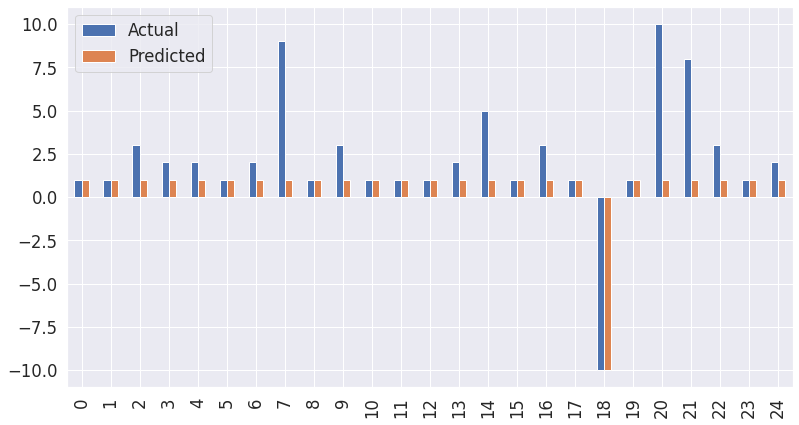

In [125]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(25)
pred.head(10)
# visualise the above comparison result
pred.plot(kind='bar', figsize=(13, 7))

## Using Random Forest Classifier

In [126]:
classifier = RandomForestClassifier(n_estimators=500,criterion= 'entropy',random_state = 0)
classifier.fit(X_train,y_train)
print("Validation Accuracy is: ")
print(classifier.score(X_val,y_val))
print("\n\n======================\n\n")
print("Test accuracy is: ")
predictions=classifier.predict(X_test)
classifier.score(X_test,y_test)

Validation Accuracy is: 
0.5802115469369766




Test accuracy is: 


0.5817568833114816

<AxesSubplot:>

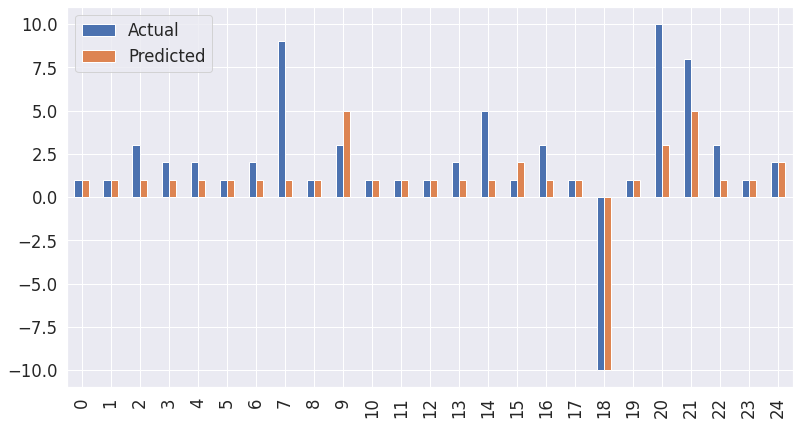

In [127]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(25)
pred.head(10)
# visualise the above comparison result
pred.plot(kind='bar', figsize=(13, 7))

## Using Gradient Boosting Algorithm

In [109]:
gb = GradientBoostingClassifier()
gb = gb.fit(X_train, y_train)

In [130]:
gb = GradientBoostingClassifier()
gb = gb.fit(X_train, y_train)
print("Validation Accuracy is: ")
print(gb.score(X_val,y_val))
print("\n\n======================\n\n")
print("Test accuracy is: ")
predictions=gb.predict(X_test)

gb.score(X_test,y_test)

Validation Accuracy is: 
0.5987219039224327




Test accuracy is: 


0.6087282262595992

In [131]:
predictions=gb.predict(X_test)


<AxesSubplot:>

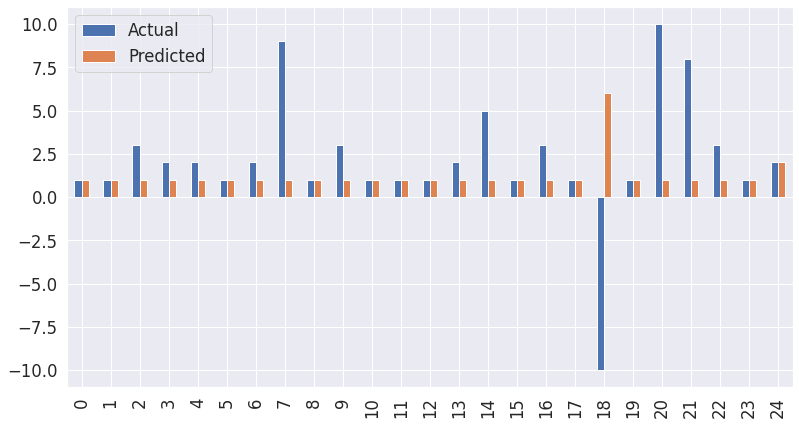

In [132]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(25)
pred.head(10)
# visualise the above comparison result
pred.plot(kind='bar', figsize=(13, 7))

In [117]:

# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [118]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [120]:
predictions = lr.predict(X_test)
predictions

array([1.48644995, 1.31034689, 1.95731183, ..., 1.28382712, 0.53285056,
       0.99575453])

In [122]:
pred = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': predictions.tolist()}).head(25)
pred.head(10)
# visualise the above comparison result
pred.plot(kind='bar', figsize=(13, 7))

,Actual,Predicted
0,1,1.486450
1,1,1.310347
2,3,1.957312
3,2,1.664686
4,2,1.861503
5,1,1.123335
6,2,1.771432
7,9,1.514448
8,1,2.258248
9,3,0.717573


<AxesSubplot:>

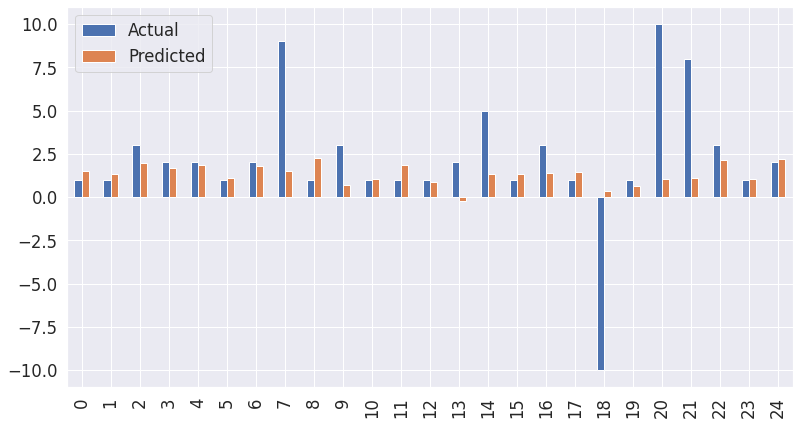

In [123]:
# visualise the above comparison result
pred.plot(kind='bar', figsize=(13, 7))

In [86]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
model = DecisionTreeRegressor(max_depth=14, min_samples_split=5, max_features=20)


In [87]:
parameter_space = {
    "max_depth": [7, 15],
    "min_samples_split": [5, 10],
    "max_features": [0, 3]
}

clf = GridSearchCV(DecisionTreeRegressor(), parameter_space, cv=4, 
                   scoring="neg_mean_absolute_error")

clf.fit(X_train, y_train)

/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 1252, in fit
    super().fit(
  File "/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 289, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_features]

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test par

/home/ml-lab/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan -1.55387692 -1.55475978         nan         nan
 -1.57768424 -1.60298456]
  warnings.warn(


GridSearchCV(cv=4, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [7, 15], 'max_features': [0, 3],
                         'min_samples_split': [5, 10]},
             scoring='neg_mean_absolute_error')

In [88]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(DecisionTreeRegressor(), parameter_space, cv=4, 
                         scoring="neg_mean_absolute_error", n_iter=100)

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

parameter_space = {
    "alpha": [1, 10, 100, 290, 500],
    "fit_intercept": [True, False],
    "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
}

clf = GridSearchCV(Ridge(random_state=3), parameter_space, n_jobs=4,
                   cv=3, scoring="neg_mean_absolute_error")

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'alpha': 500, 'fit_intercept': False, 'solver': 'lsqr'}


In [90]:
ridge_model = Ridge(random_state=3, **clf.best_params_)


In [91]:
ridge_model.fit(X_train, y_train);


In [92]:
from sklearn.metrics import mean_absolute_error

y_pred = ridge_model.predict(X_test)
ridge_mae = mean_absolute_error(y_test, y_pred)
print("Ridge MAE =", ridge_mae)

Ridge MAE = 1.7919865153881476


In [93]:
ridge_model.score(X_test,y_test)

0.022879344676235425

In [94]:
from sklearn.neighbors import KNeighborsRegressor
parameter_space = {
    "n_neighbors": [100,200,300],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    "leaf_size": [1,2,20,50]
}

clf = GridSearchCV(KNeighborsRegressor(), parameter_space, cv=3, 
                   scoring="neg_mean_absolute_error", n_jobs=4)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

Best parameters:
{'algorithm': 'brute', 'leaf_size': 1, 'n_neighbors': 100, 'weights': 'distance'}


In [95]:
knn_model = KNeighborsRegressor(**clf.best_params_)

In [96]:
knn_model.fit(X_train, y_train);


In [97]:
pred=knn_model.predict(X_test)

In [98]:
print(pred)

[1.71699278 1.03294753 1.39585374 ... 2.22291432 1.71707889 2.01631477]


In [99]:
knn_model.score(X_test,y_test)

0.35102928551497625

In [263]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR

parameter_space = \
    {
        "kernel": ["poly", "linear", "rbf", "sigmoid"],
        "degree": [3, 5],
        "coef0": [0, 3, 7],
        "gamma":[1e-3, 1e-1, 1/X_train.shape[1]],
        "C": [1, 10, 100],
    }

clf = GridSearchCV(SVR(), parameter_space, cv=3, n_jobs=4,
                   scoring="neg_mean_absolute_error")

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

/Users/a.h./opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/a.h./opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-263-e71d97345159>", line 16, in <module>
    clf.fit(X_train, y_train)
  File "/Users/a.h./opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "/Users/a.h./opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 841, in fit
    self._run_search(evaluate_candidates)
  File "/Users/a.h./opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 1288, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/Users/a.h./opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py", line 795, in evaluate_candidates
    out = parallel(delayed(_fit_and_score)(clone(base_estimator),
  File "/Users/a.h

TypeError: object of type 'NoneType' has no len()

In [ ]:
svr_model = SVR(**clf.best_params_)
svr_model.fit(X_train, y_train);

svr_model.score(X_test,y_test)